In [21]:
import spacy
import numpy as np
from collections import Counter
from word2number import w2n
import string, re, json
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import random

In [2]:
nlp = spacy.load("en_core_web_sm", disable=["ner","textcat","parser"])

In [67]:
def toNum(word):
    try: return w2n.word_to_num(word)
    except:
        return word

def normalize_text(s):
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text): # additional: converting numbers to digit form
        return " ".join([str(toNum(w)) for w in text.split()])

    def remove_punc(text):
        exclude = set(string.punctuation) - set(['.'])
        text1 = "".join(ch for ch in text if ch not in exclude)
        return re.sub(r"\.(?!\d)", "", text1) # remove '.' if it's not a decimal point

    def lower(text):
        return text.lower()
    
    def lemmatization(text):
        return " ".join([nlp(token)[0].lemma_ for token in text.split()])

    if len(s.strip()) == 1:
        # accept article and punc if input is a single char
        return white_space_fix(lower(s))
    elif len(s.strip().split()) == 1: 
        # accept article if input is a single word
        return lemmatization(white_space_fix(remove_punc(lower(s))))

    return lemmatization(white_space_fix(remove_articles(remove_punc(lower(s)))))

In [10]:
# VQA Eval (SQuAD style EM, F1)
def compute_vqa_metrics(cands, a):
    if len(cands) == 0: return (0,0,0)
    bow_a = normalize_text(a).split()
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        bow_c = normalize_text(c).split()
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg)

In [72]:
human_img_json = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/human_img2.json", "r"))
C = [[str(datum['CuratedEvalAnswer'])] for datum in human_img_json]
A = [str(datum['A']).replace('"', "") for datum in human_img_json]
F1_avg_scores = []
F1_max_scores = []
EM_scores = []
pr_scores = []
re_scores = []
F1_avg_bertscores = []
F1_max_bertscores = []
hard = []
middle = []
for cands, a in zip(C, A):
    assert len(cands)==1
    F1_avg, F1_max, EM, RE, PR = compute_vqa_metrics(cands, a)
    F1_avg_scores.append(F1_avg)
    F1_max_scores.append(F1_max)
    EM_scores.append(EM)
    
    pr_scores.append(PR)
    re_scores.append(RE)
    
    if RE < 0.1:
        hard.append((PR, RE, cands[0], a))
    if RE < 0.9 and RE > 0.1:
        middle.append((PR, RE, cands[0], a))
    #F1_avg_bertscore, F1_max_bertscore = compute_bertscore(cands, a)
    #F1_avg_bertscores.append(F1_avg_bertscore)
    #F1_max_bertscores.append(F1_max_bertscore)
print("F1_avg = ", np.mean(F1_avg_scores))
print("F1_max = ", np.mean(F1_max_scores))
print("EM = ", np.mean(EM_scores))
print("precision = ", np.mean(pr_scores))
print("recall = ", np.mean(re_scores))
#print("F1_avg_bertscore = ", np.mean(F1_avg_bertscores))
#print("F1_max_bertscore = ", np.mean(F1_max_bertscores))

F1_avg =  0.29015513975767765
F1_max =  0.29015513975767765
EM =  0.06719653179190752
precision =  0.21522747266346445
recall =  0.7601812666299661


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


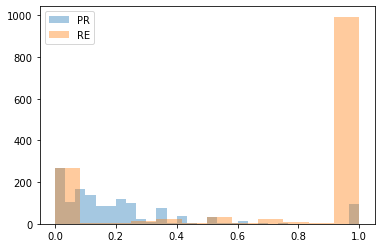

In [73]:
sns.distplot(pr_scores, kde=False, label="PR")
sns.distplot(re_scores, kde=False, label="RE")
plt.legend()

In [74]:
print(len(hard))
random.sample(hard, 10)

266


[(0, 0, 'It is rectangular.', 'A diamond.'),
 (0, 0, 'Cross-hatch', 'Cross hatch.'),
 (0, 0, 'The buttons on the Sopransaksofon are silver', 'white'),
 (0, 0, "Only the O'hare Airport has a moving walkway.", 'no'),
 (0,
  0,
  'A male Northern Cardinal does have a beak that is thicker than its eyeball.',
  'Yes'),
 (0, 0, 'Yes, she is.', 'no'),
 (0,
  0,
  'The trees outside of the Bangkok Palace are trimmed into spheres.',
  'Circles'),
 (0, 0, 'No, it does not.', 'Yes'),
 (0, 0, 'One flat side faces the soccer field.', '3'),
 (0,
  0,
  'The background of the sign is grey, while the lettering is black.',
  'green')]

In [75]:
print(len(middle))
random.sample(middle, 10)

124


[(0.2857142857142857,
  0.4,
  'The entrance to Parker Hall has more columns.',
  'Parker Hall at Bates College'),
 (0.3333333333333333,
  0.3333333333333333,
  'The seats are white.',
  'red and white'),
 (0.1,
  0.2,
  'You could sit in air conditioned comfort at Marble slab',
  '14 Market Square in Knoxville'),
 (0.2,
  0.25,
  'The deepest indent is in the center.',
  'in the middle towards the bottom'),
 (0.23529411764705882,
  0.6666666666666666,
  'Munro House in South Branch has a cupola like detail upon the top while the Orchard Terrace Apartments do not.',
  'Munro House, South Branch, New Jersey.'),
 (0.2,
  0.6,
  'The four characters depicted in Portrait of the Four Tetrarchs are shown to be holding each other',
  'Embracing each other, in pairs.'),
 (0.06666666666666667,
  0.5,
  'The "Pasing" sign on the Munich tram type A 2.2 in the Munich transport museum is higher than the "256".',
  'The Pasign sign.'),
 (0.4,
  0.26666666666666666,
  'The helmet, chestpiece, and ite

In [58]:
normalize_text('Five.')

'5'